In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read datasets
flight_df = pd.read_csv('./data/Flight_Level_Data.csv', parse_dates=['scheduled_departure_datetime_local','actual_departure_datetime_local'])
pnr_df = pd.read_csv('./data/PNR_Flight_Level_Data.csv', parse_dates=['pnr_creation_date'])
remarks_df = pd.read_csv('./data/PNR_Remark_Level_Data.csv')
bag_df = pd.read_csv('./data/Bag_Level_Data.csv', parse_dates=['bag_tag_issue_date'])
airport_df = pd.read_csv('./data/Airports_Data.csv')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [40]:

# Step 2: Baggage complexity
print("\nStep 2: Calculating baggage complexity...")
if 'bag_group' not in bag_df.columns:
    print("bag_group column missing! Creating from bag_type...")
    bag_df['bag_group'] = bag_df['bag_type']

bag_counts = bag_df.groupby(['flight_number','scheduled_departure_date_local','bag_group']).size().unstack(fill_value=0)
bag_counts['Checked'] = bag_counts.get('Checked', 0)
bag_counts['Transfer'] = bag_counts.get('Transfer', 0)
bag_counts['transfer_to_checked_ratio'] = bag_counts['Transfer'] / bag_counts['Checked'].replace(0,1)
bag_counts = bag_counts.reset_index()
print("Baggage counts per flight:\n", bag_counts.head())

# Merge baggage info with flight_df safely
flight_df_scaled = flight_df.merge(
    bag_counts[['flight_number','scheduled_departure_date_local','transfer_to_checked_ratio']],
    on=['flight_number','scheduled_departure_date_local'],
    how='left'
)
flight_df_scaled['transfer_to_checked_ratio'] = flight_df_scaled['transfer_to_checked_ratio'].fillna(0)



Step 2: Calculating baggage complexity...
bag_group column missing! Creating from bag_type...
Baggage counts per flight:
 bag_group  flight_number scheduled_departure_date_local  Hot Transfer  Origin  \
0                      1                     2025-08-10             0       0   
1                      2                     2025-08-02             0       0   
2                      2                     2025-08-04             0       0   
3                      2                     2025-08-06             0       0   
4                      2                     2025-08-09             0       0   

bag_group  Transfer  Checked  transfer_to_checked_ratio  
0                 2        0                        2.0  
1                 3        0                        3.0  
2                 3        0                        3.0  
3                12        0                       12.0  
4                 1        0                        1.0  


In [41]:

# Step 3: Total passengers and load factor
print("\nStep 3: Calculating total passengers and load factor...")
passengers_per_flight = pnr_df.groupby(['flight_number','scheduled_departure_date_local'])['total_pax'].sum().reset_index()
passengers_per_flight.rename(columns={'total_pax':'total_passengers'}, inplace=True)
print("Passengers per flight:\n", passengers_per_flight.head())

flight_df_scaled = flight_df_scaled.merge(
    passengers_per_flight,
    on=['flight_number','scheduled_departure_date_local'],
    how='left'
)
flight_df_scaled['total_passengers'] = flight_df_scaled['total_passengers'].fillna(0)
flight_df_scaled['load_factor'] = flight_df_scaled['total_passengers'] / flight_df_scaled['total_seats'].replace(0,1)
print(flight_df_scaled[['flight_number','total_passengers','load_factor']].head())



Step 3: Calculating total passengers and load factor...
Passengers per flight:
    flight_number scheduled_departure_date_local  total_passengers
0              3                     2025-08-01               177
1              3                     2025-08-02               183
2              3                     2025-08-03               199
3              3                     2025-08-04               199
4              3                     2025-08-05               180
   flight_number  total_passengers  load_factor
0           4792                65     0.855263
1            920               171     1.023952
2           1776               180     1.084337
3           5790                55     1.100000
4           1398               136     0.819277


In [42]:

# Step 4: Special Service Requests (SSR)
print("\nStep 4: Calculating SSR per passenger...")
ssr_per_flight = remarks_df.groupby(['flight_number','pnr_creation_date']).size().reset_index(name='ssr_count')
ssr_per_flight_total = ssr_per_flight.groupby('flight_number')['ssr_count'].sum().reset_index()
flight_df_scaled = flight_df_scaled.merge(ssr_per_flight_total, on='flight_number', how='left')
flight_df_scaled['ssr_count'] = flight_df_scaled['ssr_count'].fillna(0)
flight_df_scaled['ssr_per_pax'] = flight_df_scaled['ssr_count'] / flight_df_scaled['total_passengers'].replace(0,1)
print(flight_df_scaled[['flight_number','total_passengers','ssr_count','ssr_per_pax']].head())



Step 4: Calculating SSR per passenger...
   flight_number  total_passengers  ssr_count  ssr_per_pax
0           4792                65         41     0.630769
1            920               171         60     0.350877
2           1776               180         41     0.227778
3           5790                55         30     0.545455
4           1398               136         96     0.705882


In [43]:

# Step 5: Ground time pressure
print("\nStep 5: Calculating ground time pressure...")
flight_df_scaled['ground_time_pressure'] = flight_df_scaled['scheduled_ground_time_minutes'] - flight_df_scaled['actual_ground_time_minutes']
flight_df_scaled['ground_time_pressure'] = flight_df_scaled['ground_time_pressure'].fillna(0)
print(flight_df_scaled[['flight_number','scheduled_ground_time_minutes','actual_ground_time_minutes','ground_time_pressure']].head())



Step 5: Calculating ground time pressure...
   flight_number  scheduled_ground_time_minutes  actual_ground_time_minutes  \
0           4792                             42                          34   
1            920                            235                         229   
2           1776                             76                          69   
3           5790                            223                          38   
4           1398                             75                          72   

   ground_time_pressure  
0                     8  
1                     6  
2                     7  
3                   185  
4                     3  


In [44]:

# Step 6: Difficulty score (normalize features)
print("\nStep 6: Computing difficulty score...")
scaler = MinMaxScaler()
features = ['load_factor','transfer_to_checked_ratio','ssr_per_pax','ground_time_pressure']
flight_df_scaled[features] = scaler.fit_transform(flight_df_scaled[features])
flight_df_scaled['difficulty_score'] = flight_df_scaled[features].sum(axis=1)
print(flight_df_scaled[['flight_number','difficulty_score']].head())



Step 6: Computing difficulty score...
   flight_number  difficulty_score
0           4792          0.969749
1            920          1.060024
2           1776          1.074377
3           5790          1.209050
4           1398          1.050190


In [45]:

# Step 7: Rank and classify flights per day
print("\nStep 7: Ranking and classifying flights per day...")
def classify_rank(df):
    df = df.sort_values('difficulty_score', ascending=False).reset_index(drop=True)
    n = len(df)
    df['difficulty_rank'] = df.index + 1
    df['difficulty_class'] = pd.cut(df['difficulty_rank'], bins=[0, n/3, 2*n/3, n], labels=['Difficult','Medium','Easy'])
    return df

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    flight_df_scaled = flight_df_scaled.groupby(
        'scheduled_departure_date_local',
        group_keys=False,
        observed=False
    ).apply(classify_rank)


flight_df_scaled.reset_index(drop=True, inplace=True)
print(flight_df_scaled[['flight_number','scheduled_departure_date_local','difficulty_score','difficulty_rank','difficulty_class']].head(20))



Step 7: Ranking and classifying flights per day...
    flight_number scheduled_departure_date_local  difficulty_score  \
0             881                     2025-08-01          1.828268   
1             972                     2025-08-01          1.749213   
2             944                     2025-08-01          1.680918   
3             845                     2025-08-01          1.675712   
4             907                     2025-08-01          1.656768   
5             909                     2025-08-01          1.550035   
6            1710                     2025-08-01          1.452335   
7            1811                     2025-08-01          1.441045   
8             219                     2025-08-01          1.428304   
9            1335                     2025-08-01          1.408784   
10           1124                     2025-08-01          1.399069   
11           1178                     2025-08-01          1.393352   
12           1215                     

In [48]:

# Step 8: Export final CSV
flight_df_scaled.to_csv('./Flight_Difficulty_Scores.csv', index=False)
print("\nCSV exported: Flight_Difficulty_Scores.csv")



CSV exported: Flight_Difficulty_Scores.csv


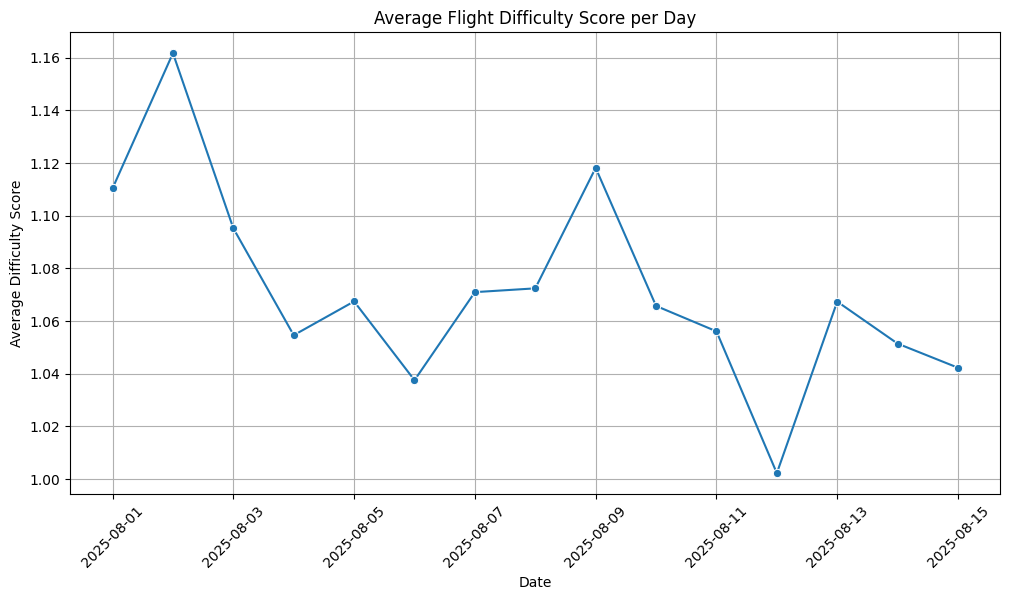

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert scheduled_departure_date_local to datetime if not already
flight_df_scaled['scheduled_departure_date_local'] = pd.to_datetime(flight_df_scaled['scheduled_departure_date_local'])

# Average difficulty score per day
daily_avg = flight_df_scaled.groupby('scheduled_departure_date_local')['difficulty_score'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_avg, x='scheduled_departure_date_local', y='difficulty_score', marker='o')
plt.title('Average Flight Difficulty Score per Day')
plt.xlabel('Date')
plt.ylabel('Average Difficulty Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



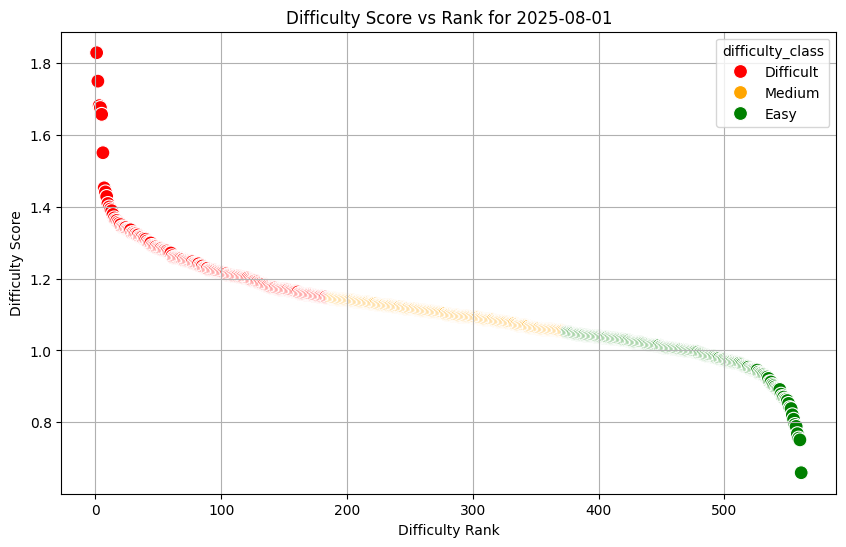

In [50]:

# Scatter plot of ranks for a sample day (pick one day)
sample_day = flight_df_scaled['scheduled_departure_date_local'].iloc[0]
day_df = flight_df_scaled[flight_df_scaled['scheduled_departure_date_local'] == sample_day]
plt.figure(figsize=(10,6))
sns.scatterplot(data=day_df, x='difficulty_rank', y='difficulty_score', hue='difficulty_class', palette=['red','orange','green'], s=100)
plt.title(f'Difficulty Score vs Rank for {sample_day.date()}')
plt.xlabel('Difficulty Rank')
plt.ylabel('Difficulty Score')
plt.grid(True)
plt.show()